# Jared Godar Regression Project

This is the overall working notebook used to acquire / prepare / clean / scale / and explore my zillo data.

The modeling and evaluation portion will be in a second notebook `zillo-modeling.ipynb`

Streamlined highlights from both notebooks can be found in the `zillo-report.ipynb` notebook.

Import libraries used in project.

In [51]:
# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

#Custim functiona
from env import host, user, password #Database credentials
import zillo_wrangle


---

## Acquire

In [52]:
# function to contact database
def get_db_url(db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"

- Look at zillow data dictionary. 
- Import minimum features (beds, bath, tax, year, fips)
- See what other columns may prove useful in model


In [53]:
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


### Takeaways: Columns of interest that may have predictive value

- `buildingqualitytypeid` Quality 
- `fireplacecnt`
- `garagecarcnt`
- `poolcnt`
- `rawcensustractandblock`
- `censustractandblock`
- `regionidzip`
- `regionidneighborhood`
- `storytypeid`


import:
- `regionidcounty`
- 
- `

Use SQL query to get single unit (`propertylandusetypeid=261`) from May-Aug, 2017 filtering for non-zero values to have fewer nulls in the first data pull to deal with.

In [63]:
def get_data_from_sql():
    query = """
    SELECT bedroomcnt as bedrooms, 
       bathroomcnt as bathrooms,
       calculatedfinishedsquarefeet as square_feet,
       yearbuilt as year,
       taxamount as taxes,
       taxvaluedollarcnt as home_value,
       fips as fips,
       regionidzip as zip_code
    FROM predictions_2017
     JOIN properties_2017 USING(parcelid)
     JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE (transactiondate >= '2017-01-01' AND transactiondate <= '2017-12-31') 
        AND propertylandusetypeid = '261'
        AND bedroomcnt > 0
        AND bathroomcnt > 0
        AND calculatedfinishedsquarefeet > 0 
        AND taxamount > 0
        AND taxvaluedollarcnt > 0
        AND fips > 0
    ORDER BY fips;
    """
    df = pd.read_sql(query, get_db_url('zillow'))
    return df

In [64]:
zillow = get_data_from_sql()
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544.0,1974.0,5419.26,430000.0,6037.0,96361.0
1,4.0,2.0,1749.0,1951.0,1432.09,96296.0,6037.0,96517.0
2,3.0,2.0,1441.0,1964.0,6194.07,469000.0,6037.0,96229.0
3,4.0,2.0,1196.0,1954.0,2140.24,113404.0,6037.0,97328.0
4,4.0,3.0,2117.0,2005.0,5635.97,253704.0,6037.0,97329.0


In [65]:
shape1 = zillow.shape
shape1

(52275, 8)

Count nulls by column

In [7]:
zillow.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55614 entries, 0 to 55613
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     55614 non-null  float64
 1   bathrooms    55614 non-null  float64
 2   square_feet  55614 non-null  float64
 3   year         55587 non-null  float64
 4   taxes        55614 non-null  float64
 5   home_value   55614 non-null  float64
 6   fips         55614 non-null  float64
 7   zip_code     55553 non-null  float64
dtypes: float64(8)
memory usage: 3.4 MB


In [9]:
# get total of null values for each row
null1 = zillow.isnull().sum()
null1

bedrooms        0
bathrooms       0
square_feet     0
year           27
taxes           0
home_value      0
fips            0
zip_code       61
dtype: int64

Lots of missing neighborhood data... Drop that column before filtering NAs. (Actually removed this field from the SQL query - now not imported and not dropped)

- [ ] Drop city as well
- [ ] Figure out how to get that information from `fips`  

GO back to mysql workbench and see how many properties have the `single residential inferred` code 279

- 55614 for single family

- 0 records for inferred single family, so no need to include it in query

---

### Vizualize distribution and outliers

- Eliminating outliers may also reduce the null value counts

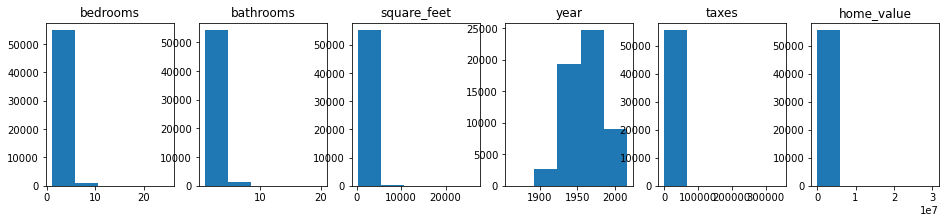

In [10]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'year_built', 'zip_code', 'propertylandusedesc']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

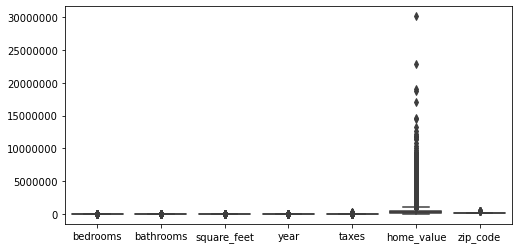

In [11]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips']))

plt.show()

Lots of outliers - especially in value

In [12]:
zillow.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))


,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
count,55614,55614,55614,55587,55614,55614,55614,55553
mean,3.31136,2.25512,1870.51,1961.23,5566.61,456862,6048.79,96599.5
std,0.924014,0.993283,964.384,21.9596,6826.01,593637,21.1611,4473.18
min,1,1,320,1862,20.24,9762,6037,95982
25%,3,2,1262,1949,2538.87,188729,6037,96197
50%,3,2,1632,1958,4138.68,330476,6037,96389
75%,4,3,2218,1976,6416.11,534747,6059,96987
max,25,20,26345,2016,342940,3.01668e+07,6111,399675


### Remove outliers

Make remove outliers function

In [13]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [14]:
zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet    float64
year           float64
taxes          float64
home_value     float64
fips           float64
zip_code       float64
dtype: object

In [15]:
zillow = remove_outliers(zillow, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxes', 'home_value'])
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,5.0,3.0,2996.0,2004.0,3238.30,191451.0,6037.0,97319.0
2,3.0,2.0,2016.0,1963.0,6965.26,554115.0,6037.0,96370.0
4,5.0,3.0,2736.0,2004.0,5301.10,252152.0,6037.0,97328.0
5,3.0,2.0,1514.0,2005.0,7040.85,582000.0,6037.0,96013.0
7,4.0,3.0,2792.0,2005.0,10036.52,824238.0,6037.0,96349.0


In [16]:
shape2 = zillow.shape
print(shape1)
print(shape2)

(55614, 8)
(48328, 8)


In [17]:
removed1 = shape1[0]-shape2[0]

In [18]:
print(f'Original records: {shape1[0]}')
print(f'Records Removed: {removed1}')
print(f'Records remaining: {shape2[0]}')

Original records: 55614
Records Removed: 7286
Records remaining: 48328


In [19]:
# get total of null values for each row
null2 = zillow.isnull().sum()
print(null1)
print(null2)

bedrooms        0
bathrooms       0
square_feet     0
year           27
taxes           0
home_value      0
fips            0
zip_code       61
dtype: int64
bedrooms        0
bathrooms       0
square_feet     0
year           20
taxes           0
home_value      0
fips            0
zip_code       32
dtype: int64


Reasonable number of null values copared to total records, go ahead and drop NAs

In [20]:
# Drop NAs
zillow = zillow.dropna()

In [21]:
shape3=zillow.shape
shape3

(48276, 8)

In [22]:
removed2=shape2[0]-shape3[0]

In [23]:
print(f'Original records: {shape2[0]}')
print(f'Records Removed: {removed2}')
print(f'Records remaining: {shape3[0]}')

Original records: 48328
Records Removed: 52
Records remaining: 48276


---

### Vizualize distributions again minus outliers

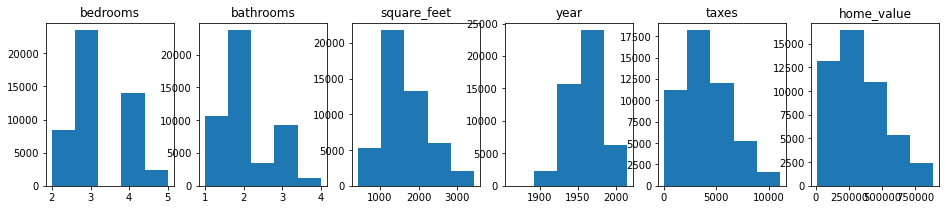

In [24]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'zip_code', 'propertylandusedesc']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

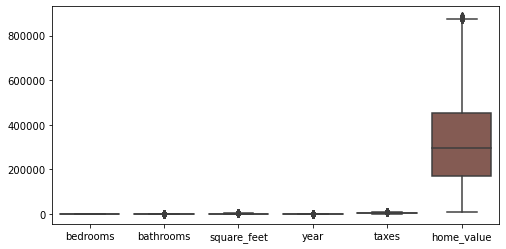

In [25]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips', 'zip_code']))

plt.show()

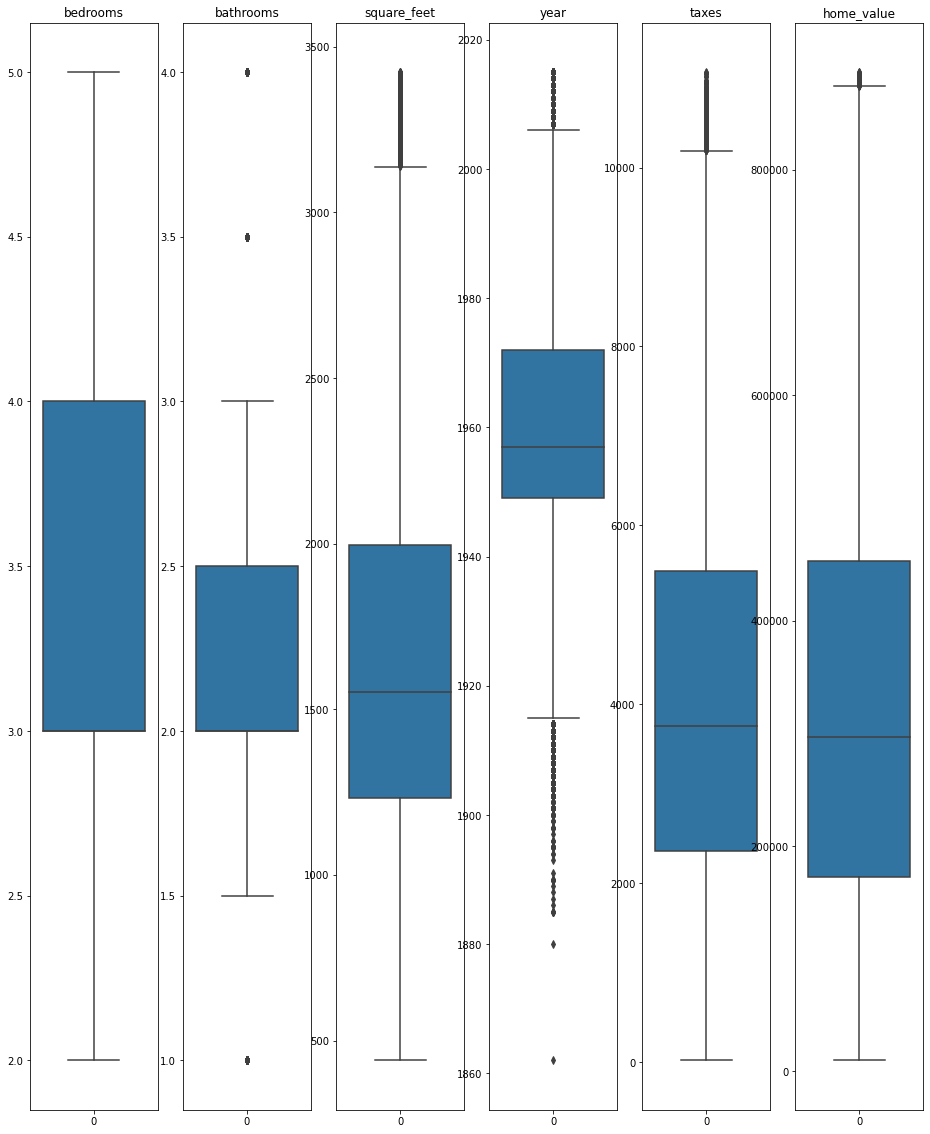

In [26]:
# List of columns
cols = [col for col in zillow.columns if col not in ['fips','zip_code', 'propertylandusedesc']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

In [27]:
zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet    float64
year           float64
taxes          float64
home_value     float64
fips           float64
zip_code       float64
dtype: object

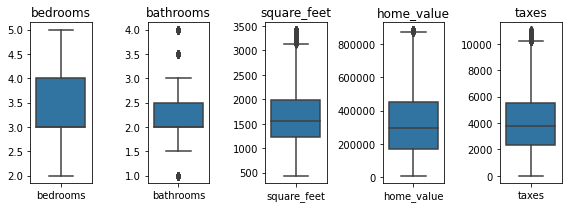

In [28]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet', 'home_value', 'taxes']

plt.figure(figsize=(8, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

In [32]:
# function to clean up my zillow df
def clean_data(df):
    '''
    This funciton takes in the zillow df and drops observations with Null values
    and handles data types returning a df with a basic clean.
    '''
    df = df.dropna()
    df["fips"] = df["fips"].astype(int)
    df["zip_code"] = df["zip_code"].astype("category")
    df["square_feet"] = df["square_feet"].astype("int")
    return df

In [33]:
zillow.shape

(48276, 8)

In [34]:
zillow = clean_data(zillow)

In [35]:
zillow.shape

(48276, 8)

Insert code here to vizualize NA's by column... lsot 2/3 of our records with current filtering. May be a way to impute or preserve or eliminate a problem column.

In [36]:
#Vizualize NA by column

In [37]:
zillow = clean_data(zillow)
print(zillow.shape)
zillow.head()

(48276, 8)


,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,5.0,3.0,2996,2004.0,3238.30,191451.0,6037,97319.0
2,3.0,2.0,2016,1963.0,6965.26,554115.0,6037,96370.0
4,5.0,3.0,2736,2004.0,5301.10,252152.0,6037,97328.0
5,3.0,2.0,1514,2005.0,7040.85,582000.0,6037,96013.0
7,4.0,3.0,2792,2005.0,10036.52,824238.0,6037,96349.0


In [38]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,48276.0,3.216070,0.784326,2.00,3.000,3.000,4.0000,5.00
bathrooms,48276.0,2.058994,0.707377,1.00,2.000,2.000,2.5000,4.00
square_feet,48276.0,1657.320283,564.625893,440.00,1233.000,1552.000,1995.0000,3424.00
year,48276.0,1959.565913,20.354878,1862.00,1949.000,1957.000,1972.0000,2015.00
taxes,48276.0,4068.313504,2250.980020,20.24,2356.075,3754.355,5490.0575,11067.72
home_value,48276.0,327540.176609,198042.983033,9762.00,172201.750,297087.500,453039.0000,886678.00
fips,48276.0,6048.816886,21.391311,6037.00,6037.000,6037.000,6059.0000,6111.00


### To Do in successve iterations beyond MVP

- [ ] (for unchecked checkbox)
- [x] (for checked checkbox)


- [ ] Add column for range...
- [ ] Import additional columns of potential use
- [ ] Derive columns from there
    - Pool (boolean)
    - Condition (bins)
    - Calculate age in years
    - Bin ages
    - Etc.
- [ ] Lookup / populate county based on `fips`
- [ ] Caculate tax rate percent (`taxes`, `home_value`)


-[] Add "inferred single family residential" code to original SQL query (not necessary, 0 records)

- [x] left join on propertylandusetype



Minor, but kind of annoying find out why `[ ]` is not rendering as a checkbox in markdown in VS Code...

---

## Split data into train, test, validate; Then create separate x/y feature/target dataframes


In [39]:
def split_my_data(df, pct=0.10):
    '''
    This divides a dataframe into train, validate, and test sets. 
    Parameters - (df, pct=0.10)
    df = dataframe you wish to split
    pct = size of the test set, 1/2 of size of the validate set
    Returns three dataframes (train, validate, test)
    '''
    train_validate, test = train_test_split(df, test_size=pct, random_state = 123)
    train, validate = train_test_split(train_validate, test_size=pct*2, random_state = 123)
    return train, validate, test

In [40]:
train, validate, test = split_my_data(zillow)

In [41]:
print(train.shape)
print(validate.shape)
print(test.shape)

(34758, 8)
(8690, 8)
(4828, 8)


---

## EDA

### Initial questions:

1. What are drivers of tax value?
2. What leads to lower tax values?
3. What factors do not impact tax value?
4. Are there any ways to combine the current data into interesting engineered features?

### Beginning exploration

- Examine pairwaise relationships
    - Crosstabs
    - Corr plots
    - Pair plots
    - Etc.

---

## Data has been aquired and cleaned, now scale

Since even our cleaned data has a fair number of outliers still, I will use the robust scaler

In [42]:
import sklearn.preprocessing
from sklearn.model_selection import train_test_split


In [43]:
train.head

<bound method NDFrame.head of        bedrooms  bathrooms  square_feet    year    taxes  home_value  fips  \
19522       3.0        4.0         2590  1991.0  4674.34    383862.0  6037   
50612       3.0        2.0         1526  1975.0  6720.52    578692.0  6059   
45562       3.0        2.0         1249  1977.0  5424.46    474325.0  6059   
39367       3.0        2.0         2735  1971.0  2522.54    207894.0  6059   
21161       4.0        3.0         2327  1952.0  2298.52    176914.0  6037   
...         ...        ...          ...     ...      ...         ...   ...   
33067       4.0        3.0         1745  1989.0  2814.72    159153.0  6037   
33614       3.0        1.0         1114  1941.0  4608.05    384164.0  6037   
49767       3.0        2.0         1891  1965.0  3280.02    329136.0  6059   
47231       3.0        2.0         1095  1955.0  3980.28    336938.0  6059   
26279       4.0        1.0         1240  1948.0  3375.03    269479.0  6037   

      zip_code  
19522  96007.0  

Text(0.5, 1.0, 'Scaled')

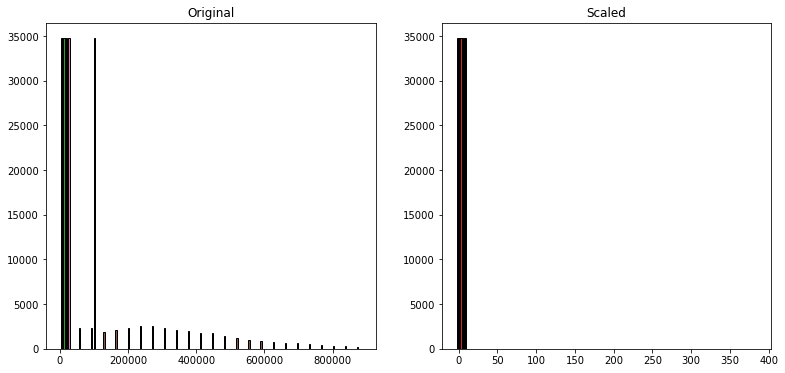

In [47]:

scaler = sklearn.preprocessing.RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(train)

train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns)
validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled, bins=25, ec='black')
plt.title('Scaled')

In [48]:
train_scaled.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,0.0,4.0,1.366623,1.478261,0.289991,0.307885,0.0,-0.497455
1,0.0,0.0,-0.031537,0.782609,0.941050,1.000083,1.0,-0.273537
2,0.0,0.0,-0.395532,0.869565,0.528666,0.629285,1.0,0.798982
3,0.0,0.0,1.557162,0.608696,-0.394673,-0.317300,1.0,0.816794
4,1.0,2.0,1.021025,-0.217391,-0.465953,-0.427367,0.0,-0.169211


In [49]:
# Split into x / y | features / target

# Setup X and y
X_train = train.drop(columns='home_value')
y_train = train.home_value

X_validate = validate.drop(columns='home_value')
y_validate = validate.home_value

X_test = test.drop(columns='home_value')
y_test = test.home_value

In [50]:
X_train.head()

,bedrooms,bathrooms,square_feet,year,taxes,fips,zip_code
19522,3.0,4.0,2590,1991.0,4674.34,6037,96007.0
50612,3.0,2.0,1526,1975.0,6720.52,6059,96183.0
45562,3.0,2.0,1249,1977.0,5424.46,6059,97026.0
39367,3.0,2.0,2735,1971.0,2522.54,6059,97040.0
21161,4.0,3.0,2327,1952.0,2298.52,6037,96265.0


---

Data is now clean and split, proceed with creating MVP model